In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
training_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/training_set'
test_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/test_set'
val_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/validation_set'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# training_path = '/content/drive/MyDrive/set/training_set'
# test_path = '/content/drive/MyDrive/set/test_set'

In [4]:
train_dataset = datasets.ImageFolder(training_path,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
test_dataset = datasets.ImageFolder(test_path,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
val_dataset = datasets.ImageFolder(val_path,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
img, label = train_dataset[1]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


In [6]:
print("Following classes are there : \n",train_dataset.classes)

Following classes are there : 
 ['arsenic', 'non_arsenic']


Label : arsenic


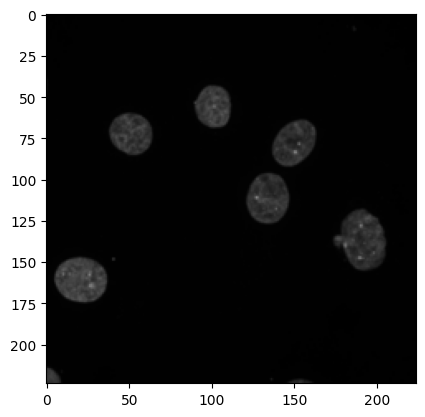

In [6]:
import matplotlib.pyplot as plt

def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[2])

In [7]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [8]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 2):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [9]:
num_classes = 2
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
total_step = len(train_loader)

In [10]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))



Epoch [20/20], Loss: 0.0511


In [13]:
#Validation
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    accuracy = correct / total
    print(f'Accuracy is {accuracy}')

Accuracy is 0.875


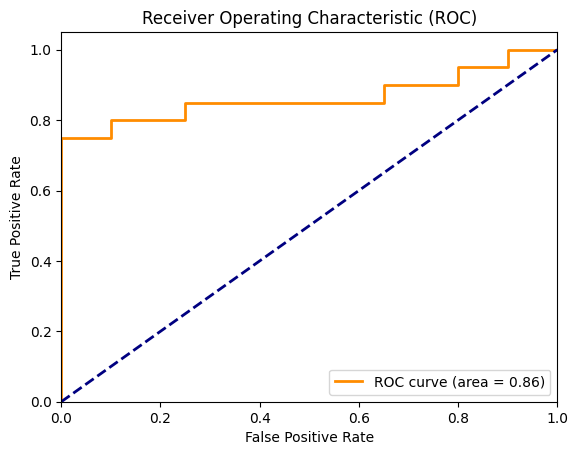

In [14]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Initialize containers for true labels and predicted probabilities
all_labels = []
all_probs = []

# Validation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Use softmax for multi-class, sigmoid for binary
        
        # Store labels and predicted probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

        del images, labels, outputs

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Assume binary classification for AUC computation
# Use the probabilities of the positive class (e.g., column index 1)
positive_probs = all_probs[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [15]:
# Example training loop
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # Validation loop (optional)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = val_outputs.max(1)
            val_correct += val_predicted.eq(val_labels).sum().item()
            val_total += val_labels.size(0)
    
    val_loss = val_loss / len(test_loader)
    val_acc = 100.0 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/20] - Train Loss: 0.0210, Train Acc: 99.17%, Val Loss: 0.1243, Val Acc: 97.50%
Epoch [2/20] - Train Loss: 0.0189, Train Acc: 99.17%, Val Loss: 4.3770, Val Acc: 65.00%
Epoch [3/20] - Train Loss: 0.1201, Train Acc: 97.50%, Val Loss: 1.2998, Val Acc: 80.00%
Epoch [4/20] - Train Loss: 0.0015, Train Acc: 100.00%, Val Loss: 9.9334, Val Acc: 50.00%
Epoch [5/20] - Train Loss: 0.0402, Train Acc: 99.17%, Val Loss: 1.0108, Val Acc: 75.00%
Epoch [6/20] - Train Loss: 0.3134, Train Acc: 93.33%, Val Loss: 12.5844, Val Acc: 50.00%
Epoch [7/20] - Train Loss: 0.1429, Train Acc: 97.50%, Val Loss: 40.3773, Val Acc: 50.00%
Epoch [8/20] - Train Loss: 0.0384, Train Acc: 97.50%, Val Loss: 6.4501, Val Acc: 50.00%
Epoch [9/20] - Train Loss: 0.0749, Train Acc: 96.67%, Val Loss: 0.0072, Val Acc: 100.00%
Epoch [10/20] - Train Loss: 0.0045, Train Acc: 100.00%, Val Loss: 0.5094, Val Acc: 82.50%
Epoch [11/20] - Train Loss: 0.0237, Train Acc: 98.33%, Val Loss: 0.0022, Val Acc: 100.00%
Epoch [12/20] - Train Lo

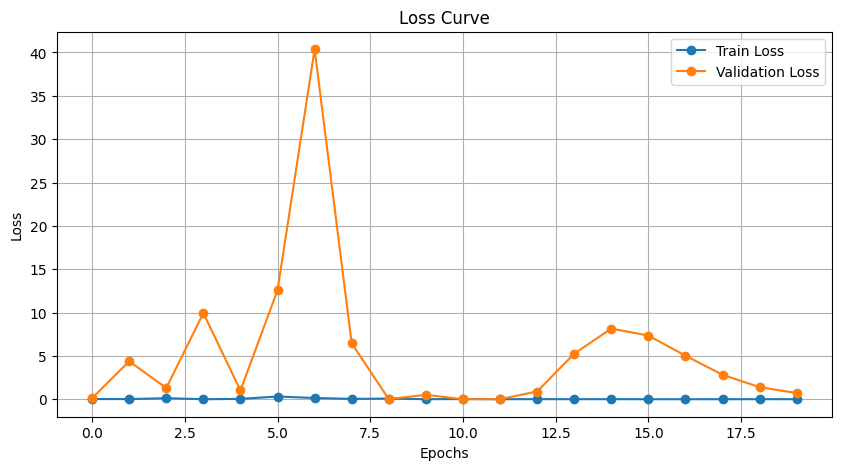

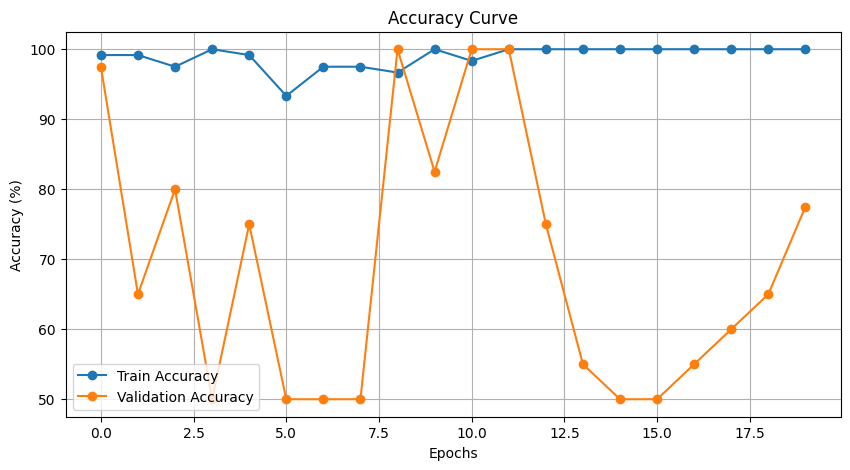

In [16]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss", marker='o')
plt.plot(val_loss_history, label="Validation Loss", marker='o')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label="Train Accuracy", marker='o')
plt.plot(val_acc_history, label="Validation Accuracy", marker='o')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
num_classes = 2
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model_cv = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cv.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
total_step = len(train_loader)

In [18]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np

def cross_validation_with_test_set(train_dataset, test_dataset, model, criterion, optimizer, 
                                 device, k_folds=5, num_epochs=10, batch_size=32):
    # Initialize K-Fold
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    # Create test loader for final evaluation
    # test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Lists to store metrics for each fold
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accs = []
    fold_val_accs = []
    fold_test_accs = []  # Store test accuracies for each fold
    
    # K-fold Cross Validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(train_dataset)))):
        print(f'FOLD {fold + 1}/{k_folds}')
        print('--------------------------------')
        
        # Sample elements for training and validation
        train_subsampler = SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        
        # Define data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                sampler=train_subsampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              sampler=val_subsampler)
        
        # Initialize model weights for this fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        
        # Training loop for this fold
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []
        
        best_val_acc = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100.0 * correct / total
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels).item()
                    _, val_predicted = val_outputs.max(1)
                    val_correct += val_predicted.eq(val_labels).sum().item()
                    val_total += val_labels.size(0)
            
            val_loss = val_loss / len(val_loader)
            val_acc = 100.0 * val_correct / val_total
            
            # Save best model for this fold
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
            
            # Store metrics
            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
            
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Load best model for this fold and evaluate on test set
        model.load_state_dict(best_model_state)
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                test_outputs = model(test_inputs)
                _, test_predicted = test_outputs.max(1)
                test_correct += test_predicted.eq(test_labels).sum().item()
                test_total += test_labels.size(0)
        
        test_acc = 100.0 * test_correct / test_total
        print(f"Test Accuracy for Fold {fold + 1}: {test_acc:.2f}%")
        
        # Store the final metrics for this fold
        fold_train_losses.append(train_loss_history)
        fold_val_losses.append(val_loss_history)
        fold_train_accs.append(train_acc_history)
        fold_val_accs.append(val_acc_history)
        fold_test_accs.append(test_acc)
    
    # Calculate average metrics across all folds
    avg_train_losses = np.mean(fold_train_losses, axis=0)
    avg_val_losses = np.mean(fold_val_losses, axis=0)
    avg_train_accs = np.mean(fold_train_accs, axis=0)
    avg_val_accs = np.mean(fold_val_accs, axis=0)
    avg_test_acc = np.mean(fold_test_accs)
    test_acc_std = np.std(fold_test_accs)
    
    print(f"\nAverage Test Accuracy: {avg_test_acc:.2f}% ± {test_acc_std:.2f}%")
    
    return {
        'fold_train_losses': fold_train_losses,
        'fold_val_losses': fold_val_losses,
        'fold_train_accs': fold_train_accs,
        'fold_val_accs': fold_val_accs,
        'fold_test_accs': fold_test_accs,
        'avg_train_losses': avg_train_losses,
        'avg_val_losses': avg_val_losses,
        'avg_train_accs': avg_train_accs,
        'avg_val_accs': avg_val_accs,
        'avg_test_acc': avg_test_acc,
        'test_acc_std': test_acc_std
    }




# Run cross validation with separate test set
results = cross_validation_with_test_set(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=model_cv,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    k_folds=5,
    num_epochs=num_epochs,
    batch_size=batch_size
)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(results['avg_train_losses'], label='Train Loss')
plt.plot(results['avg_val_losses'], label='Validation Loss')
plt.title('Average Loss Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['avg_train_accs'], label='Train Accuracy')
plt.plot(results['avg_val_accs'], label='Validation Accuracy')
plt.title('Average Accuracy Across Folds')
plt.legend()
plt.show()

# Plot test accuracies across folds
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(results['fold_test_accs']) + 1), results['fold_test_accs'])
plt.axhline(y=results['avg_test_acc'], color='r', linestyle='--', label='Average')
plt.title('Test Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


FOLD 1/5
--------------------------------


KeyboardInterrupt: 